In [62]:
# install dependencies not included by Colab
# use pip3 to ensure compatibility w/ Google Deep Learning Images 
!pip3 install -q pydicom 
!pip3 install -q tqdm 
!pip3 install -q imgaug

In [63]:
import os
import sys
import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import pydicom
from imgaug import augmenters as iaa

%matplotlib inline

In [64]:
# load MDI client library
!pip install --upgrade --quiet mdai
import mdai
mdai.__version__

'0.5.7'

In [65]:
# Root directory of the project
ROOT_DIR = os.path.abspath('./lesson3-data')
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, 'logs')

if not os.path.exists(ROOT_DIR):
    os.makedirs(ROOT_DIR)
os.chdir(ROOT_DIR)

In [5]:
##Install Matterport's Mask-RCNN model from github. (https://github.com/matterport/Mask_RCNN)

!git clone https://github.com/matterport/Mask_RCNN.git
os.chdir('Mask_RCNN')

fatal: destination path 'Mask_RCNN' already exists and is not an empty directory.


In [66]:
!pwd
!ls

/home/jupyter/lesson3-data/Mask_RCNN/lesson3-data
lesson3-data
mdai_public_project_LxR6zdR2_annotations_labelgroup_all_2018-09-05-185713.json
mdai_public_project_LxR6zdR2_images_2018-08-20-184248
mdai_public_project_LxR6zdR2_images_2018-08-20-184248.zip


In [67]:
! cat /home/jupyter/lesson3-data/Mask_RCNN/requirements.txt

numpy
scipy
Pillow
cython
matplotlib
scikit-image
tensorflow==1.15.0
keras==2.0.8
opencv-python
h5py
imgaug
IPython[all]


In [68]:
!pip3 install -r requirements.txt
!python3 setup.py install

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'
python3: can't open file 'setup.py': [Errno 2] No such file or directory


In [69]:
## NEW
import tensorflow  as tf
import keras as kf
print(tf.__version__)
print(kf.__version__)

1.15.0
2.0.8


In [70]:
# Import Mask RCNN
sys.path.append(os.path.join(ROOT_DIR, 'Mask_RCNN'))  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

In [71]:
## Create an mdai client
mdai_client = mdai.Client(domain='public.md.ai', access_token="54588a008e5f0e39c69e294bbc1dbe8f")

Successfully authenticated to public.md.ai.


In [72]:
p = mdai_client.project('LxR6zdR2', path='./lesson3-data')

Using path './lesson3-data' for data.
Preparing annotations export for project LxR6zdR2...                                                
Preparing images export for project LxR6zdR2...                                                     


18.7MB [00:00, 78.2MB/s]                            
  0%|          | 0.00/3.18G [00:00<?, ?B/s]

Success: annotations data for project LxR6zdR2 ready.


3.18GB [00:53, 64.2MB/s]                            


Extracting archive: mdai_public_project_LxR6zdR2_images_2018-08-20-184248.zip
Success: images data for project LxR6zdR2 ready.


In [73]:
# this maps label ids to class ids
labels_dict = {'L_ylR0L8':0, # background 
               'L_DlqEAl':1, # lung opacity 
              }

print(labels_dict)
p.set_labels_dict(labels_dict)
p.show_label_groups()

{'L_ylR0L8': 0, 'L_DlqEAl': 1}
Label Group, Id: G_R28gN5, Name: Default group
	Labels:
	Id: L_ylR0L8, Name: No Lung Opacity
	Id: L_DlqEAl, Name: Lung Opacity



In [74]:
p.show_datasets()

Datasets:
Id: D_ao3XWQ, Name: stage 1 train



In [75]:
dataset = p.get_dataset_by_id('D_ao3XWQ')
dataset.prepare()

In [76]:
dataset.show_classes()

Label id: L_ylR0L8, Class id: 0, Class text: No Lung Opacity
Label id: L_DlqEAl, Class id: 1, Class text: Lung Opacity


In [77]:
anns = dataset.get_annotations()

In [78]:
## Train / test split
train_dataset, valid_dataset = mdai.common_utils.train_test_split(dataset)

Num of instances for training set: 23115, validation set: 2569


In [79]:
anns = dataset.get_annotations(labels_dict.keys(), verbose=True)

Dataset contains 28989 annotations, filtered by label ids dict_keys(['L_ylR0L8', 'L_DlqEAl']).


In [80]:
# These parameters have been changed to reduce run-time per epoch at the expense 
# of training performance

class DetectorConfig(Config):
    """Configuration for training pneumonia detection on the RSNA pneumonia dataset.
    Overrides values in the base Config class.
    """
    NAME = 'pneumonia'
    GPU_COUNT = 1
    IMAGES_PER_GPU = 16 # on aws, use 16
    BACKBONE = 'resnet50'
    NUM_CLASSES = 2  # background + 1 pneumonia classes
    IMAGE_MIN_DIM = 64
    IMAGE_MAX_DIM = 64
    #RPN_ANCHOR_SCALES = (32, 64)
    TRAIN_ROIS_PER_IMAGE = 16
    MAX_GT_INSTANCES = 3
    DETECTION_MAX_INSTANCES = 3
    DETECTION_MIN_CONFIDENCE = 0.9
    DETECTION_NMS_THRESHOLD = 0.1
    POST_NMS_ROIS_TRAINING = 200
    RPN_TRAIN_ANCHORS_PER_IMAGE = 16
    STEPS_PER_EPOCH = 100 
    TOP_DOWN_PYRAMID_SIZE = 32
     
config = DetectorConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     16
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.1
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 16
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  64
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  64
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [64 64  3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                   

In [81]:
class DetectorDataset(utils.Dataset):
    """Dataset class for training pneumonia detection on the RSNA pneumonia dataset.
    """

    def __init__(self, source_name, dataset, orig_height, orig_width):
        super().__init__(self)
        
        # add classes 
        for k, v in dataset.classes_dict.items():
            if v['class_id'] is not 0: 
                self.add_class(source_name, v['class_id'], v['class_text'])

        # add images 
        img_ids = dataset.get_image_ids()
        imgs_anns_dict = dataset.imgs_anns_dict
        
        #########################################################
        # WARNING: Using only the first 1000 images to reduce 
        #          run-time for demonstration only 
        # To run all images, do: for i, fp in enumerate(img_ids):
        #########################################################
        
        #for i, fp in enumerate(img_ids[:10000]):
        for i, fp in enumerate(img_ids):
            annotations = imgs_anns_dict[fp]
            self.add_image(source_name, image_id=i, path=fp, 
                           annotations=annotations, orig_height=orig_height, orig_width=orig_width)
            
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        ds = pydicom.read_file(
            fp)
        image = ds.pixel_array
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
        count = len(annotations)
        if count == 0:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            assert(dataset.label_id_to_class_id(a['labelId']) == 0)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(annotations):
                if a['data'] is not None:
                    x = int(a['data']['x'])
                    y = int(a['data']['y'])
                    w = int(a['data']['width'])
                    h = int(a['data']['height'])
                    mask_instance = mask[:, :, i].copy()
                    cv2.rectangle(mask_instance, (x, y), (x+w, y+h), 255, -1)
                    mask[:, :, i] = mask_instance
                    class_ids[i] = dataset.label_id_to_class_id(a['labelId'])
        return mask.astype(np.bool), class_ids.astype(np.int32)

In [82]:
# Training dataset
source_name = 'pneumonia'
dataset_train = DetectorDataset(source_name, train_dataset, 1024, 1024)
dataset_train.prepare()

# Validation dataset
dataset_val = DetectorDataset(source_name, valid_dataset, 1024, 1024)
dataset_val.prepare()

(-0.5, 1023.5, 1023.5, -0.5)

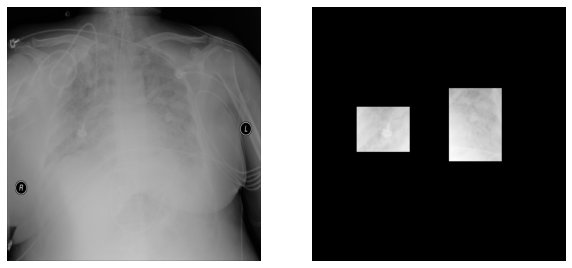

In [83]:
##Display a few images

# Load and display random samples
image_id = 22 #random.choice(dataset_train.image_ids)
image = dataset_train.load_image(image_id)
#image = dataset_train.load_image(78)
mask, class_ids = dataset_train.load_mask(image_id)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image[:, :, 0], cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
masked = np.zeros(image.shape[:2])
for i in range(mask.shape[2]):
    masked += image[:, :, 0] * mask[:, :, i]
plt.imshow(masked, cmap='gray')
plt.axis('off')

In [84]:

model = modellib.MaskRCNN(mode='training', config=config, model_dir=MODEL_DIR)
model.keras_model.metrics_tensors = []

augmentation = iaa.SomeOf((0, 1), [
    iaa.Fliplr(0.5),
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25),
        shear=(-8, 8)
    ),
    iaa.Multiply((0.9, 1.1))
])

In [33]:
import warnings 

NUM_EPOCHS = 1

# Train Mask-RCNN Model 

print()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=NUM_EPOCHS, 
            #augmentation=augmentation, # uncomment to enable augmentation
            layers='all')


Starting at epoch 0. LR=0.001

Checkpoint Path: /home/jupyter/lesson3-data/logs/pneumonia20200808T1429/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)

In [ ]:
from datetime import datetime
import warnings 

NUM_EPOCHS = 5

# Train Mask-RCNN Model 

warnings.filterwarnings("ignore")
now = datetime.now()
dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
print("Start : date and time =", dt_string)	
print()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=NUM_EPOCHS, 
            #augmentation=augmentation, # uncomment to enable augmentation
            layers='all')
print()
now = datetime.now()
dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
print("End : date and time =", dt_string)	

Start : date and time = 09/08/2020 09:07:55


Starting at epoch 0. LR=0.001

Checkpoint Path: /home/jupyter/lesson3-data/logs/pneumonia20200809T0907/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a        

In [86]:
#print(model.model_dir)
#%cd /home/jupyter/lesson3-data/Mask_RCNN/lesson3-data/logs
!pwd

/home/jupyter/lesson3-data/Mask_RCNN/lesson3-data


In [98]:
#model_path="/home/jupyter/lesson3-data/logs/pneumonia20200809T0907/mask_rcnn_pneumonia_0003.h5"
model_path="/home/jupyter/lesson3-data/logs/pneumonia20200808T1623/mask_rcnn_pneumonia_0006.h5"
print('Found model {}'.format(model_path))

Found model /home/jupyter/lesson3-data/logs/pneumonia20200808T1623/mask_rcnn_pneumonia_0006.h5


In [85]:
# select trained model 
"""
dir_names = next(os.walk(model.model_dir))[1]
key = config.NAME.lower()
dir_names = filter(lambda f: f.startswith(key), dir_names)
dir_names = sorted(dir_names)

if not dir_names:
    import errno
    raise FileNotFoundError(
        errno.ENOENT,
        "Could not find model directory under {}".format(self.model_dir))
    
fps = []
# Pick last directory
for d in dir_names: 
    dir_name = os.path.join(model.model_dir, d)
    # Find the last checkpoint
    checkpoints = next(os.walk(dir_name))[2]
    checkpoints = filter(lambda f: f.startswith("mask_rcnn"), checkpoints)
    checkpoints = sorted(checkpoints)
    if not checkpoints:
        print('No weight files in {}'.format(dir_name))
    else: 
      
      checkpoint = os.path.join(dir_name, checkpoints[-1])
      fps.append(checkpoint)
"""
#model_path = sorted(fps)[-1]


StopIteration: 

In [99]:

class InferenceConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()
inference_config.display()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.1
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  64
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  64
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [64 64  3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     

In [102]:
def show_randoms(dataset):
    fig = plt.figure(figsize=(10,20))

    num_imgs = 20
    for i in range(num_imgs):
        image_id = random.choice(dataset.image_ids)
        print("Image ID is ",image_id)
        original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, inference_config, 
                                   image_id, use_mini_mask=False)
     
        plt.subplot(num_imgs, 2, 2*i + 1)
        visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                    dataset.class_names,
                                    colors=get_colors_for_class_ids(gt_class_id), ax=fig.axes[-1])
        plt.title('Ground Truth')
        
        plt.subplot(num_imgs, 2, 2*i + 2)
        
        # turn off verbose if you don't want debug messages 
        results = model.detect([original_image],verbose=1)
        r = results[0]
        visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                    dataset.class_names, r['scores'], 
                                    colors=get_colors_for_class_ids(r['class_ids']), ax=fig.axes[-1])
        
        AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id,gt_mask,
                                                             r['rois'],r['class_ids'],r['scores'], 
                                                             r['masks'])
        print('AP ',AP,' precisions ',precisions,' recalls ',recalls)
        #visualize.plot_precision_recall(AP, precisions, recalls)
        #visualize.plot_overlaps(gt_class_id, r['class_ids'], r['scores'],overlaps, dataset.class_names)
        plt.title('Prediction')

def get_colors_for_class_ids(class_ids):
    colors = []
    for class_id in class_ids:
        if class_id == 1:
            colors.append((.941, .204, .204))
    return colors

Image ID is  1168

*** No instances to display *** 

Processing 1 images
image                    shape: (64, 64, 3)           min:    0.00000  max:  248.00000  uint8
molded_images            shape: (1, 64, 64, 3)        min: -123.70000  max:  144.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:   64.00000  int64
anchors                  shape: (1, 1023, 4)          min:   -5.74665  max:    5.73077  float32
AP  nan  precisions  [0. 0. 0. 0.]  recalls  [ 0. nan nan  1.]
Image ID is  2272

*** No instances to display *** 

Processing 1 images
image                    shape: (64, 64, 3)           min:    0.00000  max:  226.00000  uint8
molded_images            shape: (1, 64, 64, 3)        min: -123.70000  max:  122.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:   64.00000  int64
anchors                  shape: (1, 1023, 4)          min:   -5.74665  max:    5.73077  float32
AP  nan  precisions  [0. 0. 0.]

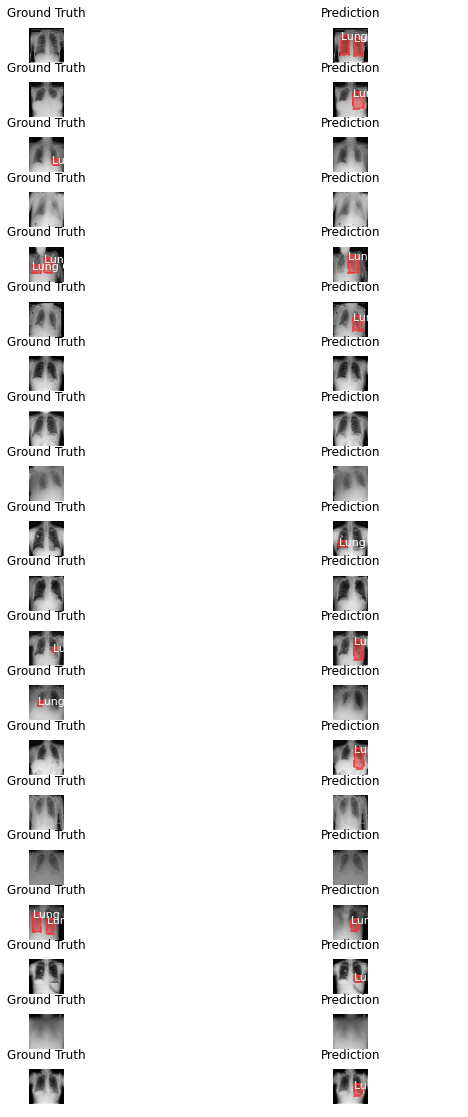

In [103]:
show_randoms(dataset_val)

Image ID is  2072

*** No instances to display *** 

Processing 1 images
image                    shape: (64, 64, 3)           min:    0.00000  max:  252.00000  uint8
molded_images            shape: (1, 64, 64, 3)        min: -123.70000  max:  148.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:   64.00000  int64
anchors                  shape: (1, 1023, 4)          min:   -5.74665  max:    5.73077  float32

*** No instances to display *** 

AP  0.0  precisions  [0. 0.]  recalls  [0. 1.]
Image ID is  2191

*** No instances to display *** 

Processing 1 images
image                    shape: (64, 64, 3)           min:    0.00000  max:  174.00000  uint8
molded_images            shape: (1, 64, 64, 3)        min: -123.70000  max:   70.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:   64.00000  int64
anchors                  shape: (1, 1023, 4)          min:   -5.74665  max:    5.73077  float32

*** No inst

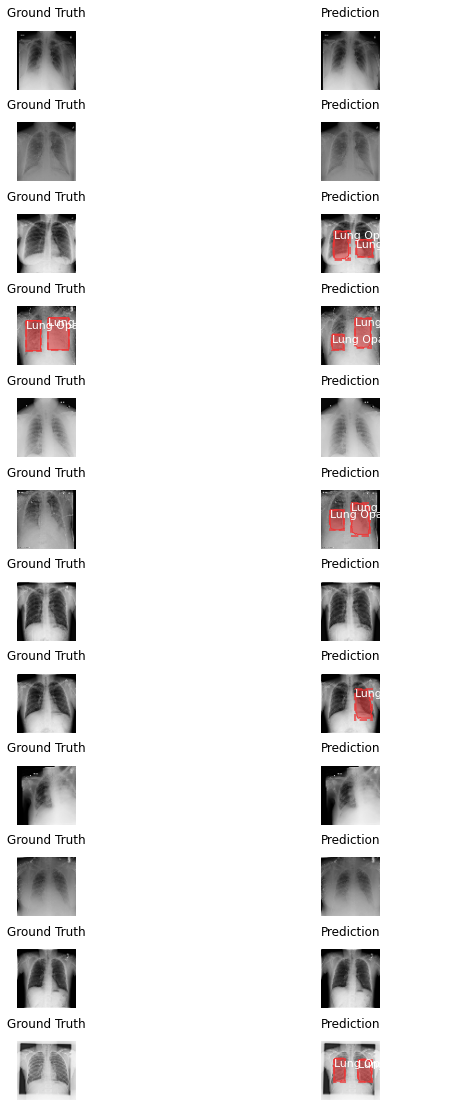